In [ ]:
import chromadb
from chromadb.utils import embedding_functions
from pathlib import Path
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import UnstructuredURLLoader
import regex as re
from datetime import datetime
from langchain_chroma import Chroma
import dotenv
from dotenv import load_dotenv
from langchain_groq import ChatGroq
from langchain_huggingface.embeddings import HuggingFaceEmbeddings
from uuid import uuid4  

# Global variables and environment variable loading
CHUNK_SIZE=100
VECTOR_STORE_DIR="../Resoruces/VectorStore"
COLLECTION_NAME="real_state"
LLM_NAME="llama-3.3-70b-versatile"
EMBEDDING_NAME="Qwen/Qwen3-Embedding-0.6B"
load_dotenv()

#Initialize instances to prevent creating everything at every run
llm= None
vector_db=None

#Initialize instances
def initializer():
    global llm, vector_db
    if llm is None: 
        llm=ChatGroq(model=LLM_NAME)
        ef=HuggingFaceEmbeddings(
            model_name=EMBEDDING_NAME,
            model_kwargs={"trust_remote_code":True} #To execute some code that might be part of the model but outside of the standar library code
        )
    if vector_db is None:
        vector_db=Chroma(
            collection_name=COLLECTION_NAME,
            persist_directory=VECTOR_STORE_DIR,
            embedding_function=ef
        )

initializer()
vector_db.reset_collection() #Just a good practice to ensure the database is clean

c:\Users\ingst\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# ------------------------------------------ Function definition

vector_db.reset_collection() #Keeping the cell clean

def document_urls(urls):
    ''' 
    Description:
        Function to extract documentation from a list of URLS into a chromadb collection
    Inputs:
        urls (list): List of URLS
    Returns:
        laoder (langchain laoder): Loader with the documents from the URLS
    '''

    
    loader=UnstructuredURLLoader(
        urls=urls,
        headers={"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) Chrome/120 Safari/537.36"}
    )

    return loader

urls=["https://www.cnbc.com/2024/12/21/how-the-federal-reserves-rate-policy-affects-mortgages.html",
      "https://www.cnbc.com/2025/09/17/federal-reserve-cuts-interest-rates-heres-what-that-means-for-you.html",
      "https://www.cnbc.com/2025/05/07/federal-reserve-interest-rates-key-ways-consumer-loans-are-affected.html"]

def chroma_update(loader,splitter):
    ''' 
    Description
        Function to update the chromadb database using chunks from langchain loader and splitter
    Inputs
        loader (langchain loader): Loader containing the documents from URL for RAG
        splitter (lanchain splitter): Langchain splitter to convert docs into chunks
    Returns
        None
    '''
    docs=loader.load()
    #Load the content
    #Create the chunks
    chunks=splitter.split_documents(docs)  
    #Create unique identifiers
    vector_db.add_documents(chunks,ids=[str(uuid4()) for _ in range(len(chunks))])

# -------------------------------------------------------------------------

#Create loader for the documents
loader=document_urls(urls)

#Split data into chunks
r_splitter=RecursiveCharacterTextSplitter(
    separators=["\n\n","\n","."," "],
    chunk_size=CHUNK_SIZE,
    chunk_overlap=30,

)

#Store chunks into database
chroma_update(loader,r_splitter)

In [5]:
#Checking that the database is working
query="30 years mortage rate"
results=vector_db.similarity_search(
    query=query,
    k=2
    )

results

[Document(id='bd5dd988-6bf2-4537-bd06-96e99100c030', metadata={'source': 'https://www.cnbc.com/2025/09/17/federal-reserve-cuts-interest-rates-heres-what-that-means-for-you.html'}, page_content='Now, the average rate for a 30-year, fixed-rate mortgage is 6.13% as of Tuesday, according to Mortgage News Daily, down from their peak at over 7% back in January.'),
 Document(id='8cf88cc7-a875-4946-b3ab-4bc8fb5c958b', metadata={'source': 'https://www.cnbc.com/2025/05/07/federal-reserve-interest-rates-key-ways-consumer-loans-are-affected.html'}, page_content='The average rate for a 30-year, fixed-rate mortgage is 6.91% as of May 6, while the 15-year, fixed-rate is 6.22%, according to Mortgage News Daily.')]

In [18]:
docs[0].metadata

{'source': 'https://www.cnbc.com/2024/12/21/how-the-federal-reserves-rate-policy-affects-mortgages.html'}

# Likely issues

## **If you retrieve too much chunks you might exceed your context window and have issues**

**Possible solutions**
* metadata filtering
* Rank the chunks in order of distance -> add chunks sucha that the added size of the chunks does not go beyond the context window limitation when you pass it to your LLM (**Chunk prioritization**)

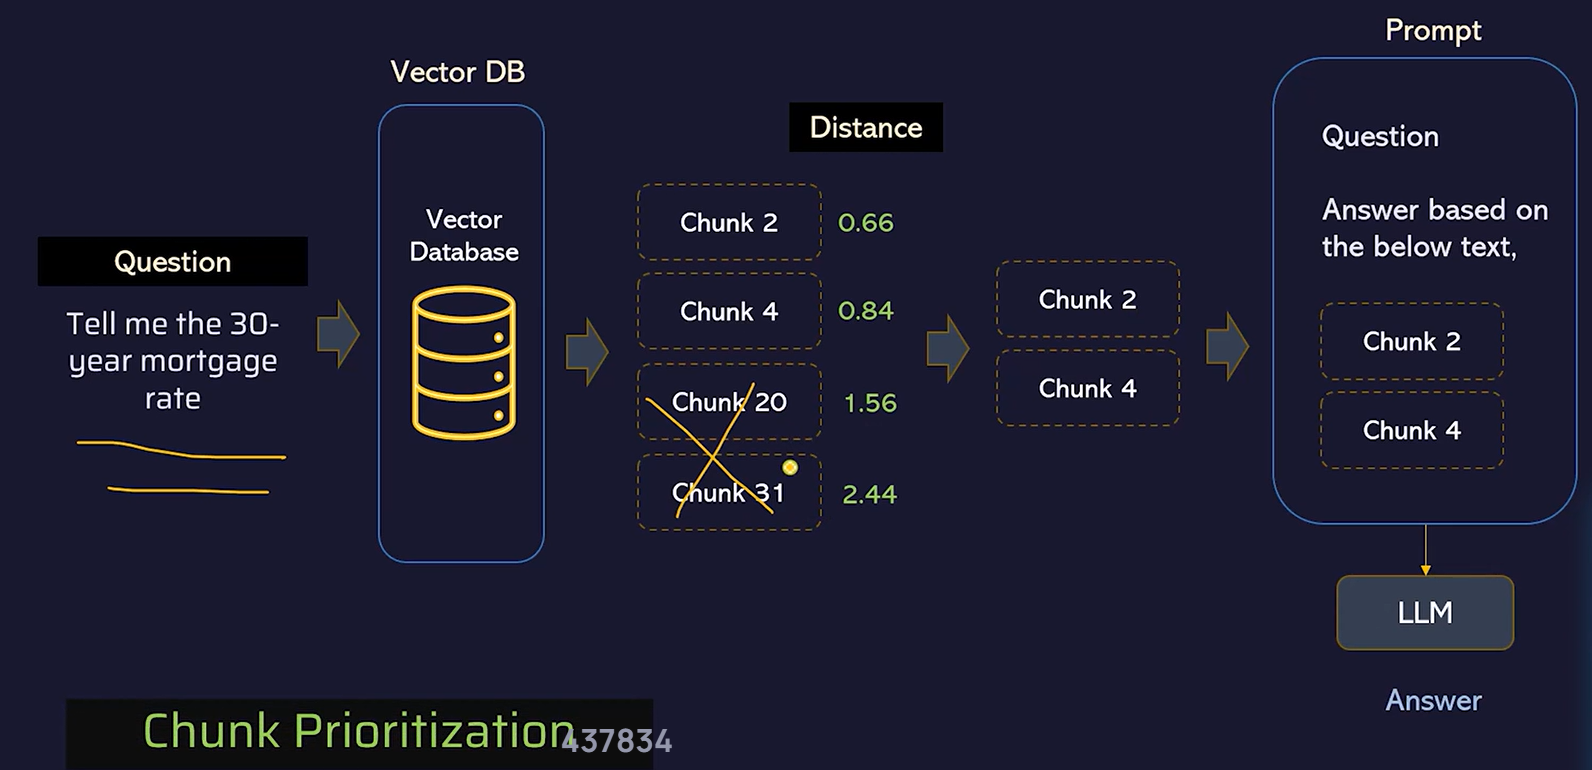


* Chunk summarization: Using an LLM to (recursevly if needed) summarize the prompt

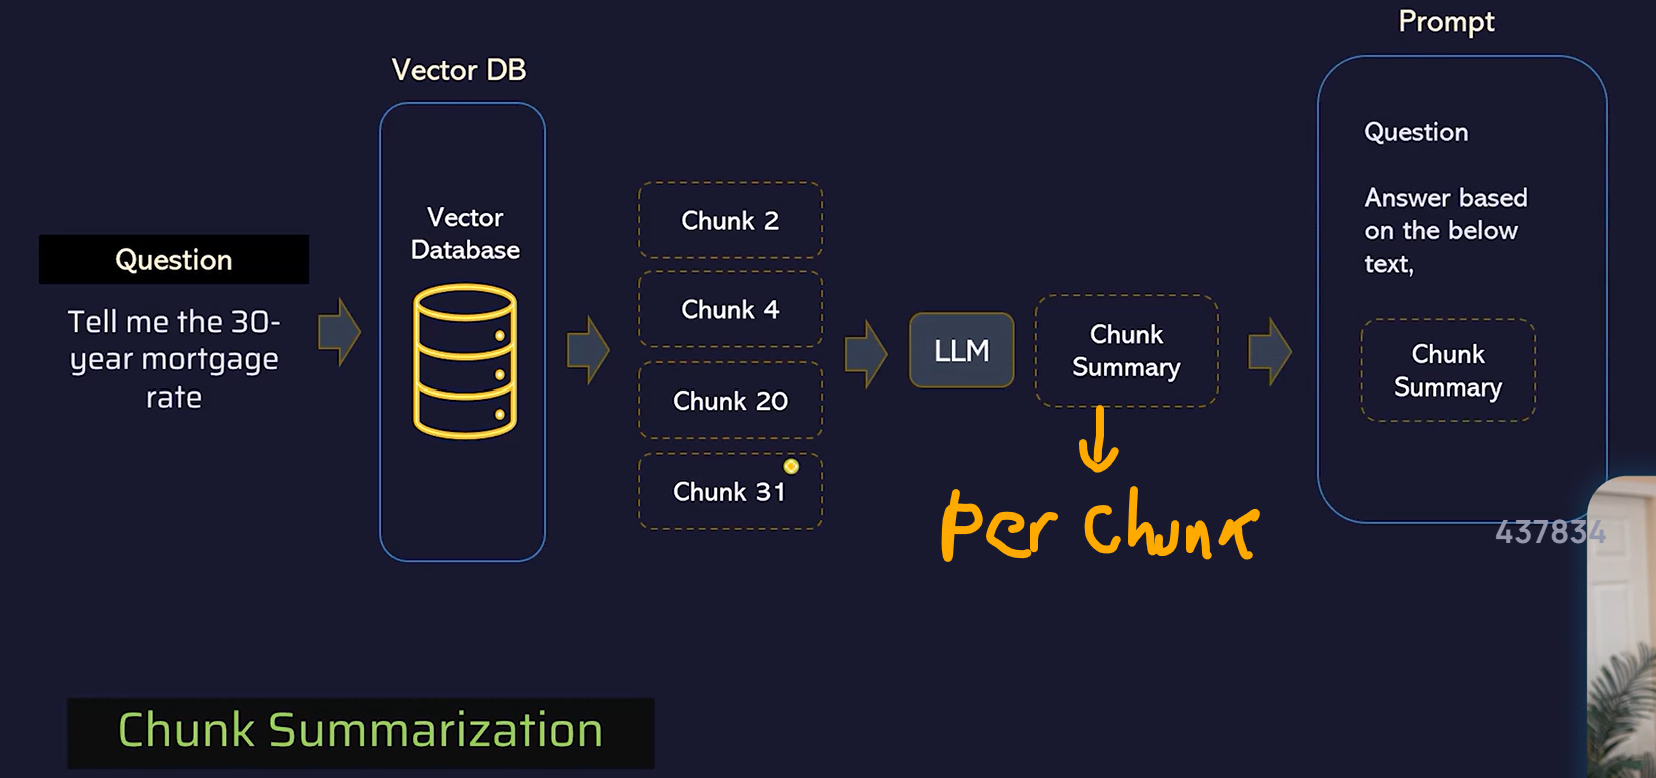



# Retrieval

In [12]:
#Number of chunks
collections=vector_db.get()

len(collections["documents"])

159

In [13]:
from langchain.chains import RetrievalQAWithSourcesChain

def generate_answer(query):
    if not vector_db:
        raise RuntimeError("Vector DB is not initialized")
    else:
        
        retriever=vector_db.as_retriever(search_kwargs={"k":10}) #To prevent context window issues
        chain=RetrievalQAWithSourcesChain.from_llm( #This is an object we will use to query from the database
            llm=llm,
            retriever=retriever)
        result=chain.invoke({"question":query},return_only_outputs=True)
        sources=result.get("sources","") #This is a dictionary. We'd like to retrieve the source of the answer, if we don't get it we will return ""
        return result["answer"],sources
    

query="Tell me what was the 30 year fixed mortagate rate along with the date"

results,sources=generate_answer(query)

results

'The 30-year fixed mortgage rate was 6.13% as of Tuesday, and 6.91% as of May 6. However, the exact date of the 6.13% rate is not specified, only that it was a Tuesday.\n'

In [20]:
sources

'https://www.cnbc.com/2025/09/17/federal-reserve-cuts-interest-rates-heres-what-that-means-for-you.html, https://www.cnbc.com/2025/05/07/federal-reserve-interest-rates-key-ways-consumer-loans-are-affected.html'

# Learning Lessons

Typicall architecture 

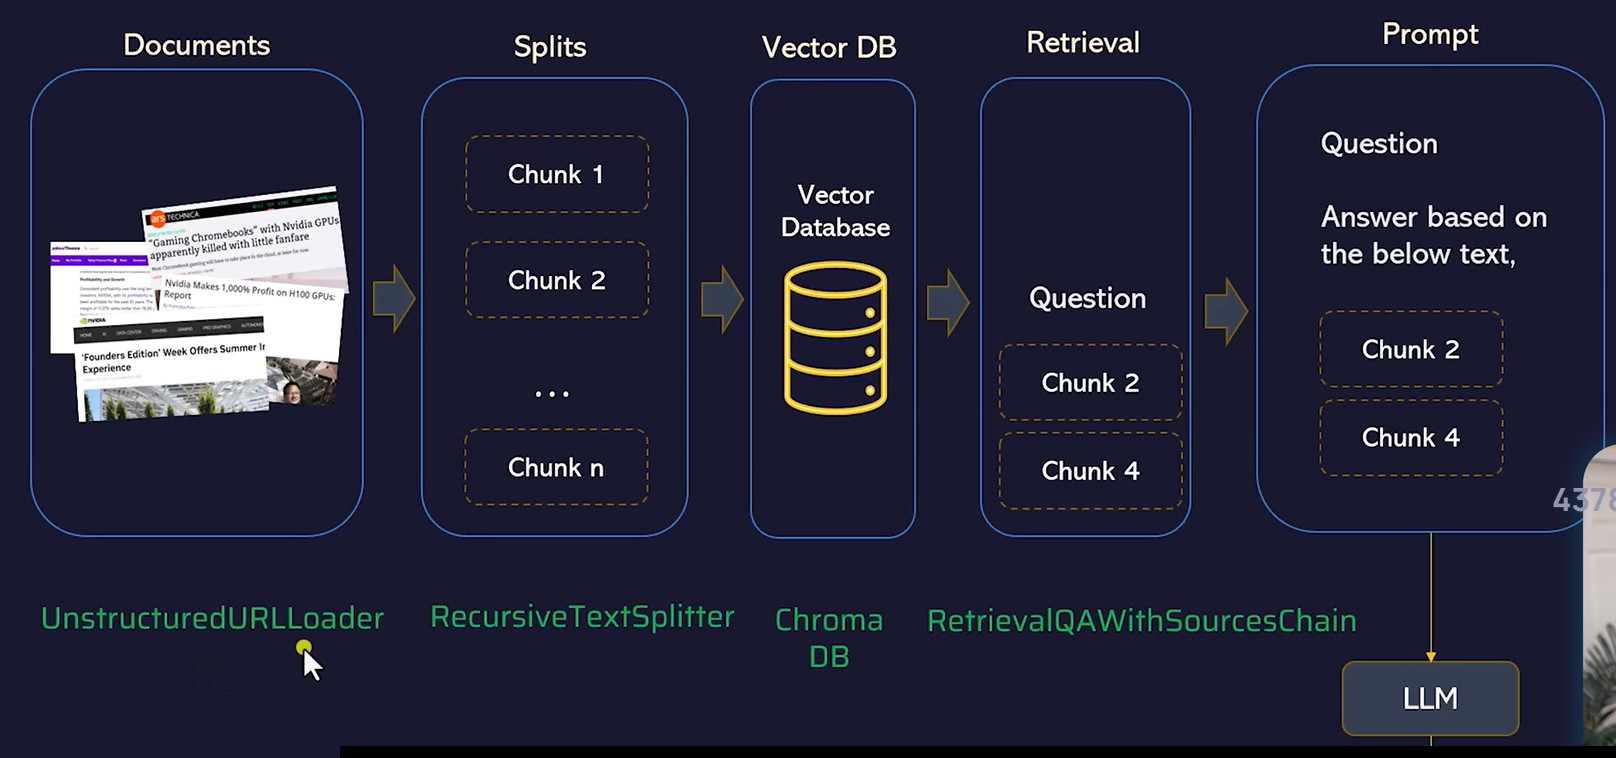

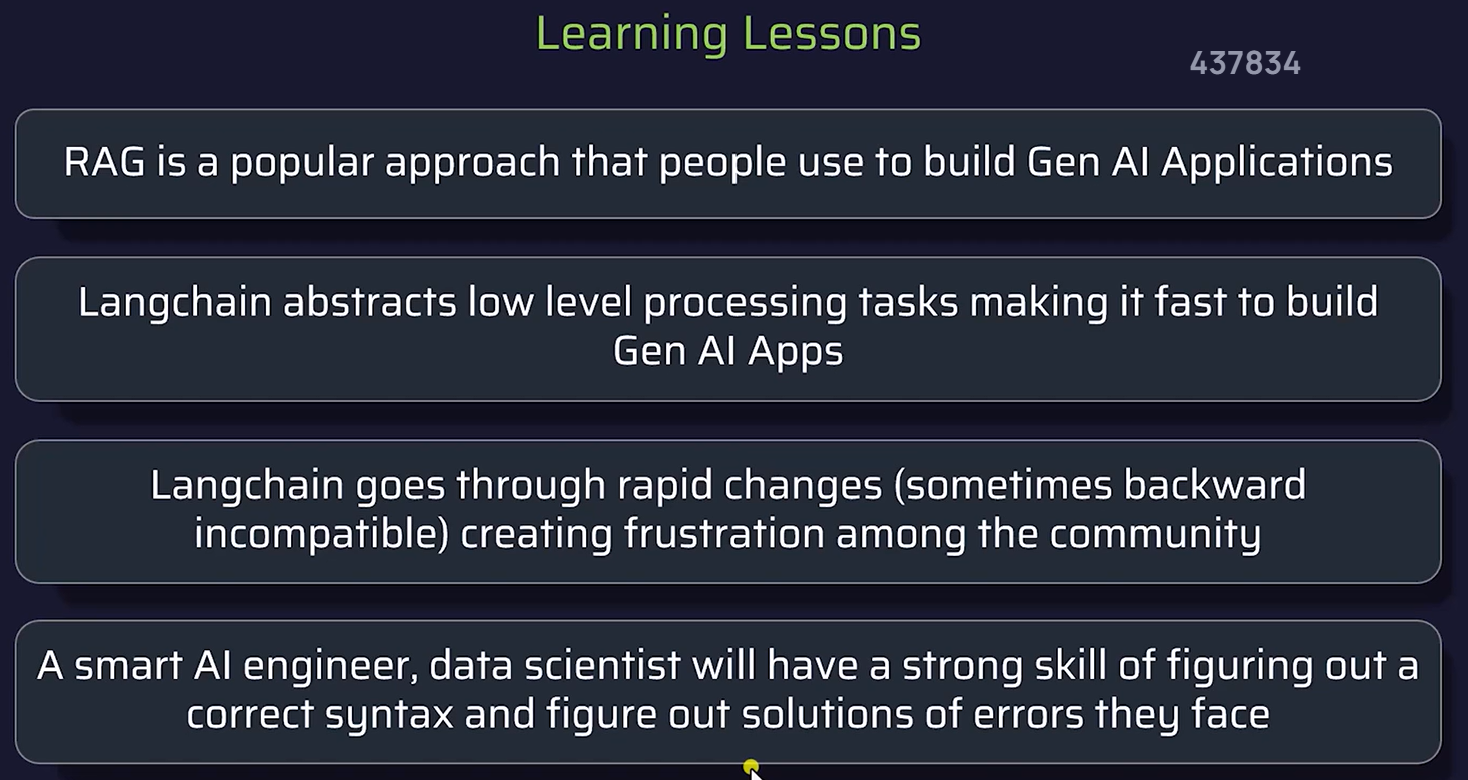

# Problem Statement: Customize the Prompt Template of Real Estate Tool
There are many instances when you'd have to modify the existing behaviour of Langchain to fit to your needs. In this exercise, you will be customizing the prompt template of the Real Estate Tool to align it with the usecase. You can refer to the following discussion to learn how to customize the RetrievalQAWithSourcesChain: [Customizing the Prompt Template](https://github.com/langchain-ai/langchain/issues/3523)
### **Tasks**
1. Create a new `prompt.py` file in the `real-estate-tool` directory. And the relevant code to append the prompt in : `langchain.chains.qa_with_sources.stuff_prompt.template` as shown below:
```python
from langchain.prompts import PromptTemplate
from langchain.chains.qa_with_sources.stuff_prompt import template

new_template = "YOUR PROMPT" + template
PROMPT = PromptTemplate(template=new_template, input_variables=["summaries", "question"])

EXAMPLE_PROMPT = PromptTemplate(
    template="Content: {page_content}\nSource: {source}",
    input_variables=["page_content", "source"],
)
```
2. Now create the two prompts as shown in the example above.
3. Once you have created the prompts, update the instantiation of `RetrievalQAWithSourcesChain` in the `rag.py` file to use the new prompt template.

In [ ]:
#Let's do better

#Create the prompt
from langchain.prompts import PromptTemplate
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.chains import create_retrieval_chain
from langchain.output_parsers import JsonOutputParser
template='''
You are a RAG assistant. You have to provide an answer for a question related to a topic with a maximum of three sentences. 
You will also pass the sources you extracted your answer from.
Condense the answer in a json like format.
If you don't know the answer say you don't know, and leave the sources as  " " or there is insufficient information in the documents

Use the following examples as guide:

Question: ¿What's the most famous Michael Jackson song? Topic: Music
-------
Content: Among Michael's many hits, “Billie Jean” stands out as his biggest hit song, topping charts worldwide and defining pop music in the 1980s. Released in 1983 as part of the Thriller album, the track captivated audiences with its catchy bassline, storytelling lyrics, and iconic rhythm
-------
{{ 
    "answer": "Billy Jean" is Michael Jackson's most famous song,
    "sources": https://furtadosschoolofmusic.com/blog/michael-jacksons-biggest-hit-why-billie-jean-still-rules-the-world/
}}
Question: ¿What's the expected mortage for 2024? Topic: Financial
-------
Content: “I think the best case scenario is we’re going to continue to see mortgage rates hover around six and a half to 7% ,in 2024” said Jordan Jackson, a global market strategist at J.P. Morgan Asset Management. “So unfortunately for those homeowners who are looking for a bit of a reprieve on the mortgage rate side, that may not come to fruition,” Jordan said in an interview with CNBC.
-------
{{ 
    "answer": The expected mortage rate in 2024 is between 6.5 to 7%,
    "sources": https://www.cnbc.com/2024/12/21/how-the-federal-reserves-rate-policy-affects-mortgages.html
}}

Question: {input} Topic: {topic}
-------
Content: {context}
-------
Final answer: '''

prompt=PromptTemplate(template=template,input_variables=["input","topic","context"])

def new_qa(query:str,topic:str):
    retriever=vector_db.as_retriever(search_kwargs={"k":10})
    qa_chain=create_stuff_documents_chain(llm,prompt)
    rag_chain=create_retrieval_chain(retriever,qa_chain)
    result=rag_chain.invoke({"input":query,"topic":topic}) #RAG question is hard defined as input key
    return result

query="Tell me what was the 30 year fixed mortagate rate along with the date"
topic="Financial"
result=new_qa(query,topic)


In [28]:
result

{'input': 'Tell me what was the 30 year fixed mortagate rate along with the date',
 'topic': 'Financial',
 'context': [Document(id='bd5dd988-6bf2-4537-bd06-96e99100c030', metadata={'source': 'https://www.cnbc.com/2025/09/17/federal-reserve-cuts-interest-rates-heres-what-that-means-for-you.html'}, page_content='Now, the average rate for a 30-year, fixed-rate mortgage is 6.13% as of Tuesday, according to Mortgage News Daily, down from their peak at over 7% back in January.'),
  Document(id='8cf88cc7-a875-4946-b3ab-4bc8fb5c958b', metadata={'source': 'https://www.cnbc.com/2025/05/07/federal-reserve-interest-rates-key-ways-consumer-loans-are-affected.html'}, page_content='The average rate for a 30-year, fixed-rate mortgage is 6.91% as of May 6, while the 15-year, fixed-rate is 6.22%, according to Mortgage News Daily.'),
  Document(id='278f047f-b9f1-4fbe-94c8-59e3ab60015a', metadata={'source': 'https://www.cnbc.com/2024/12/21/how-the-federal-reserves-rate-policy-affects-mortgages.html'}, pag